Title: Box 2

Author: Ruth Hanna

Email: rhanna@broadinstitute.org; jdoench@broadinstitute.org

Last updated: 2020-02-26

This notebook contains the code used to generate the figures in Box 2.

In [5]:
import pandas as pd 
import numpy as np
from numpy.random import normal, seed
import random
from math import floor, log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,gaussian_kde
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

We use pDNA sequencing data from the Brunello library as a starting point for this analysis. These data are available in Supplementary Data File 1 of Sanson et al. 2018 (https://www.nature.com/articles/s41467-018-07901-8).

In [7]:
# Load the pDNA raw read counts
df = pd.read_csv('/Users/rhanna/software-tools/brunello_pdna.txt',sep='\t')
df.head()

,sgRNA Sequence,pDNA
0,AAAAAAAATCCGGACAATGG,522
1,AAAAAAAGGATGGTGATCAA,511
2,AAAAAAATGACATTACTGCA,467
3,AAAAAAATGTCAGTCGAGTG,200
4,AAAAAACACAAGCAAGACCG,286


To simulate random noise, we generate a normal distribution centered at 1 with a standard deviation of 0.1. We then multiple each row of the pDNA reads by this random factor. We do this twice, to simulate two "replicates."

In [8]:
def add_randomness(row):
    rand = normal(1,0.1)
    return row['pDNA']*rand

seed(1)
df['A'] = df.apply(add_randomness,axis=1)
seed(2)
df['B'] = df.apply(add_randomness,axis=1)

We then log-transform the raw read counts for each "replicate" and for the original pDNA.

In [11]:
def get_lognorm(scores):
    cols = list(scores)[1:]
    for col in cols:
        # Calculate the log-normalized reads per million
        # Add a pseudocount of 1
        scores[col + ';lognorm'] = scores[col].apply(lambda x: log(float(x)/float(scores[col].sum())*1000000 + 1,2))
    return scores

df = get_lognorm(df)
df.head()

To get log-fold-change values for each "replicate," we subtract off the log-normalized read counts for the pDNA.

In [16]:
df['A-pDNA'] = df['A;lognorm'] - df['pDNA;lognorm']
df['B-pDNA'] = df['B;lognorm'] - df['pDNA;lognorm']
df.head()

,sgRNA Sequence,pDNA,A,B,pDNA;lognorm,A;lognorm,B;lognorm,A-pDNA,B-pDNA
0,AAAAAAAATCCGGACAATGG,522,606.790828,500.245240,4.192756,4.398222,4.134821,0.205466,-0.057935
1,AAAAAAAGGATGGTGATCAA,511,479.739247,508.124765,4.163726,4.077280,4.156094,-0.086446,-0.007632
2,AAAAAAATGACATTACTGCA,467,442.334379,367.239642,4.041390,3.967376,3.718348,-0.074014,-0.323042
3,AAAAAAATGTCAGTCGAGTG,200,178.540628,232.805416,2.930437,2.788705,3.122695,-0.141733,0.192257
4,AAAAAACACAAGCAAGACCG,286,310.750658,234.707742,3.388394,3.496531,3.133092,0.108137,-0.255302


Finally, we plot the replicate correlations for the log-normalized reads and the log-fold-change values. The log-normalized reads are highly correlated due to the underlying distribution of the pDNA. However, the log-fold-change values show that there is no true signal.

In [18]:
def plot_fig(x,y,name,ticks,xlabel,ylabel):
    corr = np.round(pearsonr(x, y)[0],2)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=20, edgecolor='')
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(1,0.05,'r = '+str(corr),fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
    return fig,ax

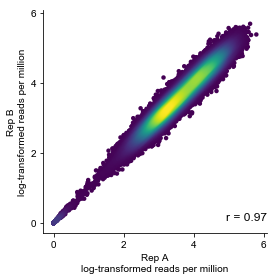

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11606f110>)

In [18]:
x = df['A;lognorm']
y = df['B;lognorm']

plot_fig(x=x,
         y=y,
         name='lognorm',
         ticks=[0,2,4,6],
         xlabel='Rep A\nlog-transformed reads per million',
         ylabel='Rep B\nlog-transformed reads per million')

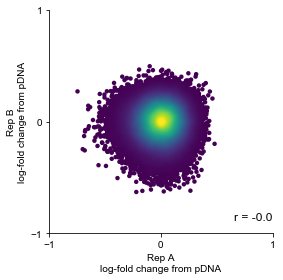

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bd14d10>)

In [19]:
x = df['A-pDNA']
y = df['B-pDNA']

plot_fig(x=x,
         y=y,
         name='lfc',
         ticks=[-1,0,1],
         xlabel='Rep A\nlog-fold change from pDNA',
         ylabel='Rep B\nlog-fold change from pDNA')

Next, we generate example replicate correlation plots showing good replicate correlations for negative and positive selection screens. For the negative selection screen, we use a screen from Sanson et al. 2018, Supplementary Data File 1, in which A375 cells were screened with the Brunello in the absence of drug. For the positive selection screen, we use a screen from Blondel et al. 2016, in which HT29 cells were screened with the Avana library and challenged with Vibrio parahaemolyticus.

Again, we calculate log-normalized reads per million and log-fold-change values for each guide. For the positive selection screen, we also median center and z-score the data. We then generate replicate correlation plots.

In [3]:
data = pd.read_csv('/Users/rhanna/software-tools/A375_Brunello_read_counts.txt',sep='\t')
data.head()

,sgRNA Sequence,pDNA,RepA,RepB
0,AAAAAAAATCCGGACAATGG,522,729,774
1,AAAAAAAGGATGGTGATCAA,511,1484,1393
2,AAAAAAATGACATTACTGCA,467,375,603
3,AAAAAAATGTCAGTCGAGTG,200,737,506
4,AAAAAACACAAGCAAGACCG,286,672,352


In [12]:
data = get_lognorm(data)

In [21]:
# The data for the positive selection screen are already log-normalized
pos_sel_data = pd.read_csv('/Users/rhanna/software-tools/Blondel_Input.txt',sep='\t')
pos_sel_data.head()

,Construct Barcode,GENE ID,INPUT_RepA,Round3_RepA,INPUT_RepB,Round3_RepB
0,AAAAAAATCCAGCAATGCAG,SHOC2,3.821264,4.350730,3.725537,0.000000
1,AAAAAACCCGTAGATAGCCT,NDUFA12,3.710173,3.332434,3.996173,2.234113
2,AAAAAAGAAGAAAAAACCAG,SDAD1,1.552909,0.285259,1.912989,0.422108
3,AAAAAAGCTCAAGAAGGAGG,FAM98A,2.880950,0.577165,2.754915,3.598627
4,AAAAAAGGCTGTAAAAGCGT,ZNF253,2.677916,1.857401,2.859897,0.307916


In [27]:
# Calculate log-fold changes from pDNA
for col in list(data)[5:]:
    data[str(col.split(';')[0]) + '_lfc'] = data[col] - data['pDNA;lognorm']
    
# Calculate log-fold changes from input 
pos_sel_data['RepA_LFC'] = pos_sel_data['Round3_RepA'] - pos_sel_data['INPUT_RepA']
pos_sel_data['RepB_LFC'] = pos_sel_data['Round3_RepB'] - pos_sel_data['INPUT_RepB']

# Median center the data
median_a = pos_sel_data['RepA_LFC'].median()
median_b = pos_sel_data['RepB_LFC'].median()
pos_sel_data['RepA_LFC_MC'] = pos_sel_data['RepA_LFC'].apply(lambda x: x - median_a)
pos_sel_data['RepB_LFC_MC'] = pos_sel_data['RepB_LFC'].apply(lambda x: x - median_b)

# Z-score the data
mean_a = pos_sel_data['RepA_LFC_MC'].mean()
mean_b = pos_sel_data['RepB_LFC_MC'].mean()
std_a = pos_sel_data['RepA_LFC_MC'].std()
std_b = pos_sel_data['RepB_LFC_MC'].std()
pos_sel_data['RepA_Z-score'] = pos_sel_data['RepA_LFC_MC'].apply(lambda x: (x - mean_a) / std_a)
pos_sel_data['RepB_Z-score'] = pos_sel_data['RepB_LFC_MC'].apply(lambda x: (x - mean_b) / std_b)

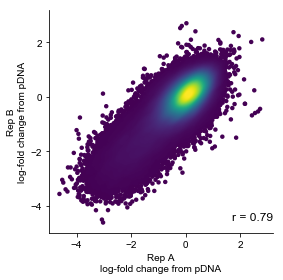

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ce67e90>)

In [23]:
x=data['RepA_lfc']
y=data['RepB_lfc']
plot_fig(x=x,y=y,name='no_drug_lfc',ticks=[-4,-2,0,2],xlabel='Rep A\nlog-fold change from pDNA',ylabel='Rep B\nlog-fold change from pDNA')


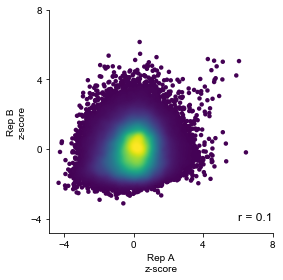

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11be71350>)

In [29]:
x=pos_sel_data['RepA_Z-score']
y=pos_sel_data['RepB_Z-score']
plot_fig(x=x,y=y,name='pos_sel',ticks=[-4,0,4,8],xlabel='Rep A\nz-score',ylabel='Rep B\nz-score')

Finally, we examine the sgRNAs that score with z-score > 3 in either Rep A only, Rep B only, or both. For each of these 3 categories, we count the number of guides that have only 1 guide per gene in that category, the number that have 2 guides per gene in that category, etc. up to all 4 guides per gene. 

As one would expect in a successful screen, than the majority of guides enriched in either Rep A only or Rep B only are singletons. In contrast, the majority of the guides enriched in both reps are not singletons; rather, there are other guides targeting the same gene that are also enriched in both reps.

In [55]:
# Rep A only
a_only = pos_sel_data.loc[(pos_sel_data['RepA_Z-score'] >= 3) & (pos_sel_data['RepB_Z-score'] < 3),:]
a_only_genes = dict(a_only['GENE ID'].value_counts())
a_only.loc[:,'guide_count'] = a_only.loc[:,'GENE ID'].apply(lambda x: a_only_genes[x])
a_only.loc[:,'guide_count'].value_counts()

1    185
2     14
Name: guide_count, dtype: int64

In [56]:
# Rep B only
b_only = pos_sel_data.loc[(pos_sel_data['RepA_Z-score'] < 3) & (pos_sel_data['RepB_Z-score'] >= 3),:]
b_only_genes = dict(b_only.loc[:,'GENE ID'].value_counts())
b_only.loc[:,'guide_count'] = b_only.loc[:,'GENE ID'].apply(lambda x: b_only_genes[x])
b_only.loc[:,'guide_count'].value_counts()

1    375
2     10
Name: guide_count, dtype: int64

In [57]:
# Rep A & B
both = pos_sel_data.loc[(pos_sel_data['RepA_Z-score'] >= 3) & (pos_sel_data['RepB_Z-score'] >= 3),:]
both_genes = dict(both.loc[:,'GENE ID'].value_counts())
both.loc[:,'guide_count'] = both.loc[:,'GENE ID'].apply(lambda x: both_genes[x])
both.loc[:,'guide_count'].value_counts()

3    6
2    6
1    5
4    4
Name: guide_count, dtype: int64

The bar plots using these values were made in GraphPad Prism.